## 教你8步绘制青岛地铁线路图

随着2021年12月30日青岛地铁1号线南段正式开通运营，青黄不接再一次告别历史，隧道+地铁的双线交通必将青黄拉得更近了。青岛地铁运营里程也来到了293.1公里，跻身大陆城市地铁排名10强，但由于11和13号线郊区段较长，外加疫情原因导致机场8号线客流较少，导致青岛地铁虽然里程排名第10，但客流强度一直感人。

借由青岛地铁1号线南段开通之际及部分微信群友们对最新版地铁线路图的渴求，作为一个入门级GIS爱好者决定试一试，画一份最新版地铁线路图供大家参考。主要目标为按照青岛地铁标准配色叠加地形图或街道图绘制带站名的地铁线路图，并保存为png或jpg格式以方便保存共享。

经过近2个月的摸鱼，知道了[Shapefile](https://zh.wikipedia.org/wiki/Shapefile)、[GeoJSON](https://geojson.org/)文件格式及QGIS等一众工具，并最终从[OpenStreetMap](https://www.openstreetmap.org/#map=9/36.1551/120.6746)网站下载到了全国矢量数据，导入QGIS后初步确认数据包含青岛地铁1号线南段。然后从https://hxkj.vip/demo/echartsMap/ 网站获取了最新版青岛市区划geojson数据。这样后续用到的基础数据基本齐了。

然后就是可视化工具的选择，结合2020年疫情回国隔离期间学习绘制归国航迹路线图的经历，首先尝试[Folium](https://python-visualization.github.io/folium/)库，但由于无法将地图保存为静态图，遂放弃。matplotlib+[basemap](https://matplotlib.org/basemap/)组合由于底图不够清晰，遂放弃。然后又搜到了[geopandas](https://geopandas.org/en/stable/)，在[pandas](https://pandas.pydata.org/)基础上添加了`geometry`属性，便于储存和处理矢量数据，研究学习发现可以很好的满足线路轮廓的绘制，而且数据处理起来也非常方便，剩下的就是如何叠加底图了，在此要感谢这篇博文[geopandas轻松叠加在线底图](https://blog.51cto.com/u_15064641/2598479)，从中学到了[contextily](https://contextily.readthedocs.io/en/latest/)库，完美解决了底图问题。

数据和绘制方案确定后，下面就到了动手撸码环节了。

### 00 导入要用到的工具库

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx

Duplicate key in file PosixPath('/home/bobcat/miniconda3/envs/option/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 264 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/bobcat/miniconda3/envs/option/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/bobcat/miniconda3/envs/option/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 412 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


以下为`matplotlib`中文乱码的配置方案，WSL下完整解决方案可参考[wsl安装字体与配置mlt](https://liuyang0001.gitee.io/2020/07/30/wsl%E5%AE%89%E8%A3%85SimHei%E5%AD%97%E4%BD%93/)

In [2]:
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False #正常显示负号
#有中文的情况，需要u'内容'
from matplotlib_scalebar.scalebar import ScaleBar

### 01 数据处理及首次绘图尝试

#### 0101 数据处理

由于`contextily`库要求投影为web墨卡托即EPSG:3857，因此在数据读取环节需要变换[crs](https://www.osgeo.cn/qgisdoc/docs/gentle_gis_introduction/coordinate_reference_systems.html)，但采用`EPSG:3857`后`geopandas`的`geometry`将不再是显性的经纬度坐标，如果不需要叠加底图的小伙伴可以取消转换。

In [3]:
#railway_data = gpd.read_file('gis_osm_railways_free_1.shp').to_crs('EPSG:3857')
railway_data = gpd.read_file('gis_osm_railways_free_1.shp')
railway_data.head()

osm_id  code     fclass                                 name  layer  \
0  4181592  6103     subway           港鐵機場快綫 MTR Airport Express      1   
1  4181898  6103     subway  大嶼山及機場鐵路 Lantau and Airport Railway     -2   
2  4182662  6103     subway           港鐵機場快綫 MTR Airport Express      2   
3  4338940  6108  funicular                       山頂纜車 Peak Tram      0   
4  4959070  6103     subway           港鐵機場快綫 MTR Airport Express      0   

  bridge tunnel                                           geometry  
0      T      F  LINESTRING (113.94339 22.32225, 113.94222 22.3...  
1      F      T  LINESTRING (114.05075 22.34109, 114.05044 22.3...  
2      T      F  LINESTRING (114.12591 22.34832, 114.12518 22.3...  
3      F      F  LINESTRING (114.14999 22.27114, 114.15014 22.2...  
4      F      F  LINESTRING (113.96220 22.29779, 113.96138 22.2...

In [4]:
print(railway_data.crs)

epsg:4326


In [5]:
railway_data = railway_data.to_crs('EPSG:3857')
railway_data.head()

osm_id  code     fclass                                 name  layer  \
0  4181592  6103     subway           港鐵機場快綫 MTR Airport Express      1   
1  4181898  6103     subway  大嶼山及機場鐵路 Lantau and Airport Railway     -2   
2  4182662  6103     subway           港鐵機場快綫 MTR Airport Express      2   
3  4338940  6108  funicular                       山頂纜車 Peak Tram      0   
4  4959070  6103     subway           港鐵機場快綫 MTR Airport Express      0   

  bridge tunnel                                           geometry  
0      T      F  LINESTRING (12684119.976 2550259.714, 12683989...  
1      F      T  LINESTRING (12696071.793 2552526.841, 12696036...  
2      T      F  LINESTRING (12704438.021 2553396.971, 12704356...  
3      F      F  LINESTRING (12707118.761 2544109.678, 12707135...  
4      F      F  LINESTRING (12686214.274 2547316.028, 12686122...

In [6]:
railway_data['fclass'].unique()

array(['subway', 'funicular', 'rail', 'monorail', 'tram', 'light_rail',
       'narrow_gauge', 'miniature_railway'], dtype=object)

通过`fclass`等于`subway`来筛选地铁线路

In [7]:
metro_data = railway_data[railway_data['fclass'] == 'subway']

In [8]:
metro_data.head()

osm_id  code  fclass                                 name  layer bridge  \
0  4181592  6103  subway           港鐵機場快綫 MTR Airport Express      1      T   
1  4181898  6103  subway  大嶼山及機場鐵路 Lantau and Airport Railway     -2      F   
2  4182662  6103  subway           港鐵機場快綫 MTR Airport Express      2      T   
4  4959070  6103  subway           港鐵機場快綫 MTR Airport Express      0      F   
5  4959071  6103  subway           港鐵機場快綫 MTR Airport Express      1      T   

  tunnel                                           geometry  
0      F  LINESTRING (12684119.976 2550259.714, 12683989...  
1      T  LINESTRING (12696071.793 2552526.841, 12696036...  
2      F  LINESTRING (12704438.021 2553396.971, 12704356...  
4      F  LINESTRING (12686214.274 2547316.028, 12686122...  
5      F  LINESTRING (12683714.662 2546652.774, 12683690...

初步选取青岛地铁线路，此处有一点需要注意，鉴于各地对地铁名称上的区别，上述`name`属性值中有青岛地铁XX线或上海轨道交通XX线或首都机场线甚至None（空值）等名称，因此建议直接按`name`属性包含城市来筛选某一城市的地铁线路。后面会有更方便的方法筛选某一城市的地铁线路。

In [9]:
metro_data_qingdao = metro_data.loc[metro_data['name'].str.contains('青岛', na=False)]

In [10]:
metro_data_qingdao.to_crs('EPSG:3857')

osm_id  code  fclass      name  layer bridge tunnel  \
113007  525096788  6103  subway  青岛地铁11号线      1      T      F   
113008  525096789  6103  subway  青岛地铁11号线      0      F      F   
113009  525096790  6103  subway  青岛地铁11号线     -1      F      T   
113010  525096792  6103  subway  青岛地铁11号线      1      T      F   
117672  546414706  6103  subway   青岛地铁2号线     -3      F      T   
...           ...   ...     ...       ...    ...    ...    ...   
244000  971320881  6103  subway   青岛地铁8号线      0      F      F   
244001  971320882  6103  subway   青岛地铁8号线      1      T      F   
244002  971341939  6103  subway   青岛地铁8号线      2      T      F   
244003  971341940  6103  subway   青岛地铁8号线      1      T      F   
244004  971341941  6103  subway   青岛地铁8号线     -1      F      T   

                                                 geometry  
113007  LINESTRING (13434685.565 4357926.229, 13434579...  
113008  LINESTRING (13434685.565 4357926.229, 13435162...  
113009  LINESTRING (13435162.468 4358027.418, 13435314...  
113010  LINESTRING (13436069.667 4358429.543, 13436133...  
117672  LINESTRING (13398750.319 4310270.586, 13398803...  
...                                                   ...  
244000  LINESTRING (13370397.212 4345229.232, 13370516...  
244001  LINESTRING (13370516.702 4344889.635, 13370707...  
244002  LINESTRING (13371075.003 4342493.090, 13371131...  
244003  LINESTRING (13371131.764 4342272.025, 13371261...  
244004  LINESTRING (13372924.576 4336969.625, 13372978...  

[84 rows x 8 columns]

In [11]:
metro_data_qingdao['name'].unique()

array(['青岛地铁11号线', '青岛地铁2号线', '青岛地铁 8号线', '青岛地铁13号线', '青岛地铁1号线',
       '青岛地铁8号线'], dtype=object)

以上我们可以看到经过初步筛选后的数据中并没有包含青岛地铁3号线，因此对3号线要进行特殊处理。

In [12]:
metro_data_qingdao_3 = metro_data.loc[metro_data['name'] == '地铁3号线']

In [13]:
metro_data_qingdao_3.to_crs('EPSG:4326')

osm_id  code  fclass   name  layer bridge tunnel  \
22010   187491086  6103  subway  地铁3号线      0      F      F   
22452   188216331  6103  subway  地铁3号线      1      F      F   
34765   232259055  6103  subway  地铁3号线      0      F      F   
37370   241123365  6103  subway  地铁3号线      1      T      F   
37374   241123369  6103  subway  地铁3号线      0      F      F   
39243   249199056  6103  subway  地铁3号线     -2      F      T   
42091   256679071  6103  subway  地铁3号线     -5      F      T   
47178   277989211  6103  subway  地铁3号线     -3      F      T   
47179   277989212  6103  subway  地铁3号线     -3      F      T   
51338   293631319  6103  subway  地铁3号线     -2      F      T   
95042   436286573  6103  subway  地铁3号线      1      T      F   
99038   462127084  6103  subway  地铁3号线      1      T      F   
205030  845719144  6103  subway  地铁3号线      0      F      F   
246222  980740412  6103  subway  地铁3号线     -3      F      T   
246223  980740413  6103  subway  地铁3号线     -4      F      T   

                                                 geometry  
22010   LINESTRING (122.00179 39.08580, 122.00090 39.0...  
22452   LINESTRING (121.71137 39.03358, 121.71195 39.0...  
34765   LINESTRING (121.99392 39.08348, 121.99682 39.0...  
37370   LINESTRING (121.71137 39.03362, 121.71113 39.0...  
37374   LINESTRING (121.69950 39.03407, 121.69858 39.0...  
39243   LINESTRING (115.97103 28.69634, 115.96805 28.6...  
42091   LINESTRING (120.30980 36.06364, 120.31109 36.0...  
47178   LINESTRING (102.77407 25.03894, 102.77364 25.0...  
47179   LINESTRING (102.71782 25.04107, 102.71776 25.0...  
51338   LINESTRING (109.02021 34.31249, 109.01798 34.3...  
95042   LINESTRING (117.21754 39.21595, 117.21961 39.2...  
99038   LINESTRING (102.78695 25.03923, 102.78289 25.0...  
205030  LINESTRING (122.00037 39.08535, 121.99968 39.0...  
246222  LINESTRING (102.74883 25.03898, 102.74670 25.0...  
246223  LINESTRING (102.71860 25.04108, 102.71782 25.0...

对青岛市经纬度范围熟悉的话，我们可以人肉筛选出`osm_id = 256679071`的三号线可能为青岛地铁号线。

In [14]:
metro_data_qingdao_3 = metro_data_qingdao_3[metro_data_qingdao_3['osm_id'] == '256679071']

In [15]:
metro_data_qingdao_3

osm_id  code  fclass   name  layer bridge tunnel  \
42091  256679071  6103  subway  地铁3号线     -5      F      T   

                                                geometry  
42091  LINESTRING (13392826.085 4309382.184, 13392969...

读取青岛市区划范围，便于展示地铁线路在各区县的分布情况。

In [16]:
geo_data_qingdao = gpd.read_file('青岛市.geojson')
geo_data_qingdao

adcode name  childrenNum     level  subFeatureIndex  \
0  370202  市南区            0  district                0   
1  370203  市北区            0  district                1   
2  370211  黄岛区            0  district                2   
3  370212  崂山区            0  district                3   
4  370213  李沧区            0  district                4   
5  370214  城阳区            0  district                5   
6  370215  即墨区            0  district                6   
7  370281  胶州市            0  district                7   
8  370283  平度市            0  district                8   
9  370285  莱西市            0  district                9   

                                            geometry  
0  MULTIPOLYGON (((120.41966 36.09099, 120.42227 ...  
1  MULTIPOLYGON (((120.41966 36.09099, 120.41096 ...  
2  MULTIPOLYGON (((119.71705 36.04185, 119.72035 ...  
3  MULTIPOLYGON (((120.48449 36.21575, 120.48631 ...  
4  MULTIPOLYGON (((120.34344 36.20834, 120.34920 ...  
5  MULTIPOLYGON (((120.57066 36.32737, 120.57032 ...  
6  MULTIPOLYGON (((120.65604 36.32216, 120.65379 ...  
7  MULTIPOLYGON (((119.71705 36.04185, 119.71728 ...  
8  MULTIPOLYGON (((120.00808 36.49822, 120.01034 ...  
9  MULTIPOLYGON (((120.63445 36.58900, 120.62719 ...

In [17]:
geo_data_qingdao = geo_data_qingdao.to_crs('EPSG:3857')
geo_data_qingdao

adcode name  childrenNum     level  subFeatureIndex  \
0  370202  市南区            0  district                0   
1  370203  市北区            0  district                1   
2  370211  黄岛区            0  district                2   
3  370212  崂山区            0  district                3   
4  370213  李沧区            0  district                4   
5  370214  城阳区            0  district                5   
6  370215  即墨区            0  district                6   
7  370281  胶州市            0  district                7   
8  370283  平度市            0  district                8   
9  370285  莱西市            0  district                9   

                                            geometry  
0  MULTIPOLYGON (((13405055.233 4313148.827, 1340...  
1  MULTIPOLYGON (((13405055.233 4313148.827, 1340...  
2  MULTIPOLYGON (((13326840.823 4306381.397, 1332...  
3  MULTIPOLYGON (((13412272.298 4330349.269, 1341...  
4  MULTIPOLYGON (((13396570.350 4329326.770, 1339...  
5  MULTIPOLYGON (((13421864.476 4345761.535, 1342...  
6  MULTIPOLYGON (((13431368.600 4345041.533, 1343...  
7  MULTIPOLYGON (((13326840.823 4306381.397, 1332...  
8  MULTIPOLYGON (((13359238.023 4369394.431, 1335...  
9  MULTIPOLYGON (((13428965.769 4381972.201, 1342...

经过上述数据处理后，下面开始首次尝试绘制青岛地铁图

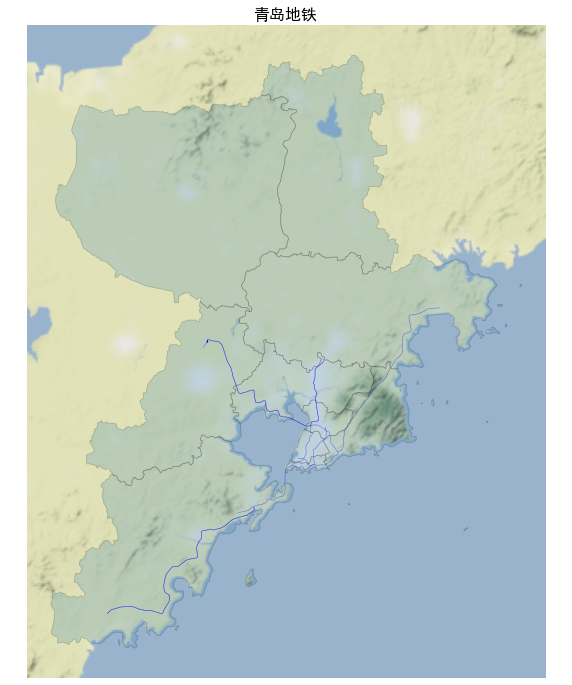

In [18]:
figure = plt.figure(figsize=(10, 12))

plt.title('青岛地铁', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

# zorder值越大，则在叠加图层中越靠上，即不会被zorder值小的图层所覆盖。
metro_data_qingdao.plot(ax=axes1, alpha=0.5, edgecolor='k', linewidth=0.5, zorder=10, color='blue')
metro_data_qingdao_3.plot(ax=axes1, alpha=0.5, edgecolor='k', linewidth=0.5, zorder=10, color='blue')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁0.png', pad_inches=0, bbox_inches='tight', dpi=300)

通过上图我们可以看到线路轮廓大致与真实路线一致，但由于线路数据的重叠，导致各线路粗细不均。不过好歹我们完成了第一步。下面我们将不断在此基础上进行优化。

In [19]:
metro_data_NA = metro_data.loc[metro_data['name'].str.contains('None', na=True)]

In [20]:
metro_data_NA

osm_id  code  fclass  name  layer bridge tunnel  \
11        12247578  6103  subway  None      2      T      F   
20        24818634  6103  subway  None      0      F      F   
120       25041427  6103  subway  None     -1      F      T   
121       25041428  6103  subway  None      0      F      F   
255       26307143  6103  subway  None      1      T      F   
...            ...   ...     ...   ...    ...    ...    ...   
255526  1016757775  6103  subway  None      0      F      F   
255527  1016757777  6103  subway  None      0      F      F   
255528  1016757778  6103  subway  None      0      F      F   
255529  1016757779  6103  subway  None      0      F      F   
255530  1016757780  6103  subway  None      0      F      F   

                                                 geometry  
11      LINESTRING (13522528.476 3668117.476, 13522515...  
20      LINESTRING (12935057.519 4851003.935, 12935055...  
120     LINESTRING (12945731.689 4875250.410, 12945743...  
121     LINESTRING (12946258.764 4876122.836, 12946322...  
255     LINESTRING (12951721.635 4857189.292, 12951696...  
...                                                   ...  
255526  LINESTRING (14092744.155 5728619.137, 14092711...  
255527  LINESTRING (14092540.541 5728642.509, 14092471...  
255528  LINESTRING (14092607.566 5728643.704, 14092540...  
255529  LINESTRING (14092559.198 5728648.627, 14092429...  
255530  LINESTRING (14092517.097 5728652.961, 14092459...  

[11871 rows x 8 columns]

In [21]:
mask_clip = gpd.clip(metro_data, geo_data_qingdao)
mask_clip = mask_clip[~mask_clip.is_empty]
mask_clip

osm_id  code  fclass      name  layer bridge tunnel  \
136279  624654571  6103  subway  青岛地铁13号线     -1      F      T   
136280  624654579  6103  subway  青岛地铁13号线     -1      F      T   
244003  971341940  6103  subway   青岛地铁8号线      1      T      F   
186269  794361559  6103  subway   青岛地铁8号线      1      T      F   
244002  971341939  6103  subway   青岛地铁8号线      2      T      F   
...           ...   ...     ...       ...    ...    ...    ...   
113008  525096789  6103  subway  青岛地铁11号线      0      F      F   
113009  525096790  6103  subway  青岛地铁11号线     -1      F      T   
242415  968613224  6103  subway  青岛地铁11号线      0      F      F   
113010  525096792  6103  subway  青岛地铁11号线      1      T      F   
127283  583560507  6103  subway      None      1      T      F   

                                                 geometry  
136279  LINESTRING (13363563.052 4285909.352, 13363840...  
136280  LINESTRING (13363562.496 4285922.131, 13363844...  
244003  LINESTRING (13371131.764 4342272.025, 13371261...  
186269  LINESTRING (13371140.002 4342273.986, 13371272...  
244002  LINESTRING (13371075.003 4342493.090, 13371131...  
...                                                   ...  
113008  LINESTRING (13434685.565 4357926.229, 13435162...  
113009  LINESTRING (13435162.468 4358027.418, 13435314...  
242415  LINESTRING (13435762.692 4358187.193, 13435843...  
113010  LINESTRING (13436069.667 4358429.543, 13436133...  
127283  LINESTRING (13437108.912 4364651.399, 13437132...  

[199 rows x 8 columns]

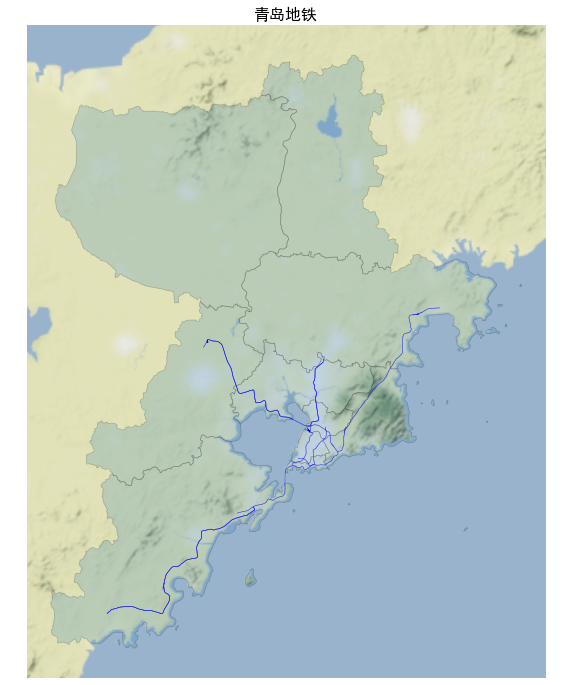

In [22]:
figure = plt.figure(figsize=(10, 12))

plt.title('青岛地铁', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

metro_data_qingdao.plot(ax=axes1, alpha=0.5, edgecolor='k', linewidth=0.5, zorder=10, color='blue')
metro_data_qingdao_3.plot(ax=axes1, alpha=0.5, edgecolor='k', linewidth=0.5, zorder=10, color='blue')
mask_clip.plot(ax=axes1, alpha=0.5, edgecolor='k', linewidth=0.5, zorder=10, color='blue')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁1.png', pad_inches=0, bbox_inches='tight', dpi=300)

In [23]:
infodata = pd.read_excel('CityData.xlsx')
infodata.rename(columns={'区划名称':'name'}, inplace=True)
infodata

城市  name       面积    常住人口-    常住人口   人口密度    政府驻地      GDP  人均GDP
0    青岛市   市南区    32.21   486643   48.66  15108  香港中路街道  1400.58  28.78
1    青岛市   市北区    65.85  1096879  109.69  16657   敦化路街道  1063.56   9.70
2    青岛市   黄岛区  2128.31  1903595  190.36    894   长江路街道  4368.53  22.95
3    青岛市   崂山区   395.79   502317   50.24   1269   金家岭街道  1011.08  20.13
4    青岛市   李沧区    99.10   737281   73.73   7440    李村街道   601.21   8.15
..   ...   ...      ...      ...     ...    ...     ...      ...    ...
305  天津市   宝坻区  1509.71   722367   72.24    478    宝平街道     0.00   0.00
306  天津市  滨海新区  2389.20  2067318  206.73    865    新港街道     0.00   0.00
307  天津市   宁河区  1298.32   395314   39.53    304     芦台镇     0.00   0.00
308  天津市   静海区  1474.03   787106   78.71    534     静海镇     0.00   0.00
309  天津市   蓟州区  1589.36   795516   79.55    501    文昌街道     0.00   0.00

[310 rows x 9 columns]

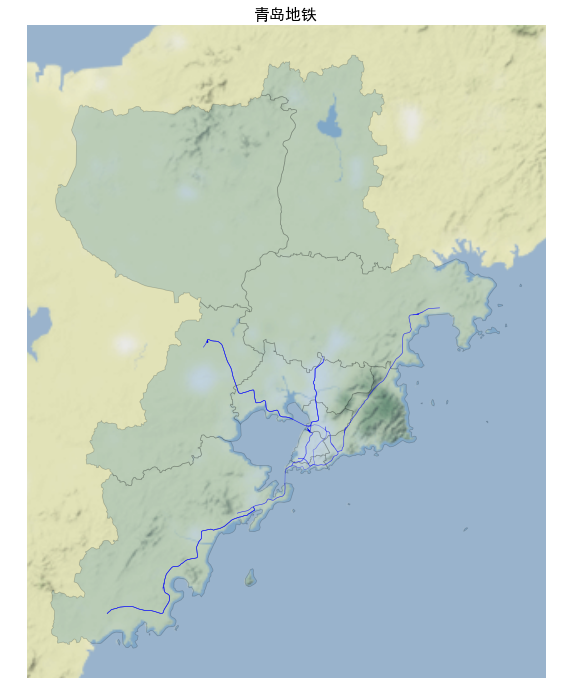

In [24]:
metro_data_qingdao_NA = gpd.clip(metro_data, geo_data_qingdao)
metro_data_qingdao_NA = metro_data_qingdao_NA[~metro_data_qingdao_NA.is_empty]
metro_data_qingdao_all = metro_data_qingdao.append(metro_data_qingdao_NA)

figure = plt.figure(figsize=(10, 12))

plt.title('青岛地铁', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

metro_data_qingdao_all.plot(ax=axes1, alpha=0.5, edgecolor='k', linewidth=0.5, zorder=10, color='blue')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁2.png', pad_inches=0, bbox_inches='tight', dpi=300)

In [25]:
metro_data_qingdao_all

osm_id  code  fclass      name  layer bridge tunnel  \
113007  525096788  6103  subway  青岛地铁11号线      1      T      F   
113008  525096789  6103  subway  青岛地铁11号线      0      F      F   
113009  525096790  6103  subway  青岛地铁11号线     -1      F      T   
113010  525096792  6103  subway  青岛地铁11号线      1      T      F   
117672  546414706  6103  subway   青岛地铁2号线     -3      F      T   
...           ...   ...     ...       ...    ...    ...    ...   
113008  525096789  6103  subway  青岛地铁11号线      0      F      F   
113009  525096790  6103  subway  青岛地铁11号线     -1      F      T   
242415  968613224  6103  subway  青岛地铁11号线      0      F      F   
113010  525096792  6103  subway  青岛地铁11号线      1      T      F   
127283  583560507  6103  subway      None      1      T      F   

                                                 geometry  
113007  LINESTRING (13434685.565 4357926.229, 13434579...  
113008  LINESTRING (13434685.565 4357926.229, 13435162...  
113009  LINESTRING (13435162.468 4358027.418, 13435314...  
113010  LINESTRING (13436069.667 4358429.543, 13436133...  
117672  LINESTRING (13398750.319 4310270.586, 13398803...  
...                                                   ...  
113008  LINESTRING (13434685.565 4357926.229, 13435162...  
113009  LINESTRING (13435162.468 4358027.418, 13435314...  
242415  LINESTRING (13435762.692 4358187.193, 13435843...  
113010  LINESTRING (13436069.667 4358429.543, 13436133...  
127283  LINESTRING (13437108.912 4364651.399, 13437132...  

[283 rows x 8 columns]

In [26]:
metro_data_qingdao_all['name'].unique()

array(['青岛地铁11号线', '青岛地铁2号线', '青岛地铁 8号线', '青岛地铁13号线', '青岛地铁1号线',
       '青岛地铁8号线', None, '地铁3号线'], dtype=object)

In [27]:
metro_data_qingdao_all['name'] = metro_data_qingdao_all['name'].str.replace('地铁3号线','青岛地铁3号线')
metro_data_qingdao_all['name'] = metro_data_qingdao_all['name'].str.replace('青岛地铁 8号线','青岛地铁8号线')
metro_data_qingdao_all['name'].unique()

array(['青岛地铁11号线', '青岛地铁2号线', '青岛地铁8号线', '青岛地铁13号线', '青岛地铁1号线', None,
       '青岛地铁3号线'], dtype=object)

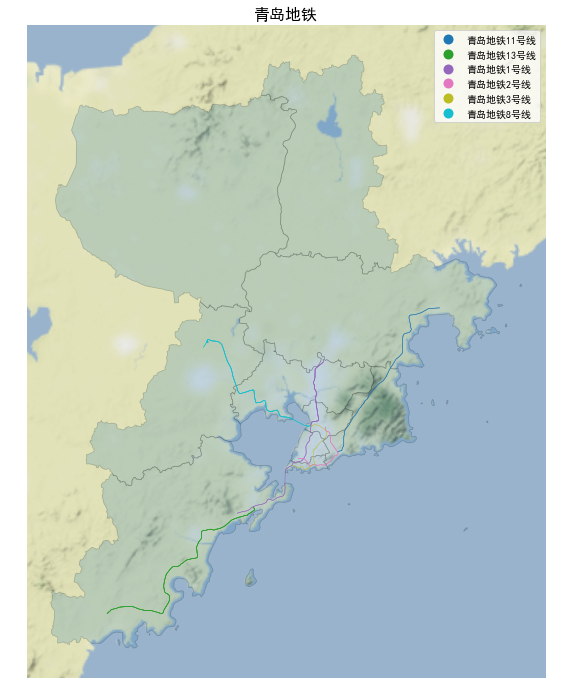

In [28]:
metro_data_qingdao_NA = gpd.clip(metro_data, geo_data_qingdao)
metro_data_qingdao_NA = metro_data_qingdao_NA[~metro_data_qingdao_NA.is_empty]

figure = plt.figure(figsize=(10, 12))

plt.title('青岛地铁', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

metro_data_qingdao_all.plot(ax=axes1, column='name', categorical=True, legend=True, linewidth=0.5, zorder=10)

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁3.png', pad_inches=0, bbox_inches='tight', dpi=300)

In [29]:
print(metro_data_qingdao_all['name'].unique())

['青岛地铁11号线' '青岛地铁2号线' '青岛地铁8号线' '青岛地铁13号线' '青岛地铁1号线' None '青岛地铁3号线']


In [30]:
metro_data_qingdao_all['name'].replace('\s+', '', regex=True, inplace=True)

In [31]:
print(metro_data_qingdao_all['name'].unique())

['青岛地铁11号线' '青岛地铁2号线' '青岛地铁8号线' '青岛地铁13号线' '青岛地铁1号线' None '青岛地铁3号线']


In [32]:
metro_qingdao_color = pd.read_excel('metro_qingdao_color.xlsx')
metro_qingdao_color

In [34]:
Lines_Palette = dict([(i,a) for i,a in zip(metro_qingdao_color['Lines'], metro_qingdao_color['Color'])])
Lines_Palette

{'青岛地铁1号线': '#EAAA00',
 '青岛地铁2号线': '#AF272F',
 '青岛地铁3号线': '#0057B8',
 '青岛地铁4号线': '#007A33',
 '青岛地铁5号线': '#981D97',
 '青岛地铁6号线': '#6CACE4',
 '青岛地铁7号线': '#AD96DC',
 '青岛地铁8号线': '#DF1995',
 '青岛地铁9号线': '#64A70B',
 '青岛地铁10号线': '#844B18',
 '青岛地铁11号线': '#304299',
 '青岛地铁12号线': '#8246AF',
 '青岛地铁13号线': '#00AB84',
 '青岛地铁14号线': '#FF585D',
 '青岛地铁15号线': '#F2ACB9',
 '青岛地铁16号线': '#71DBD4'}

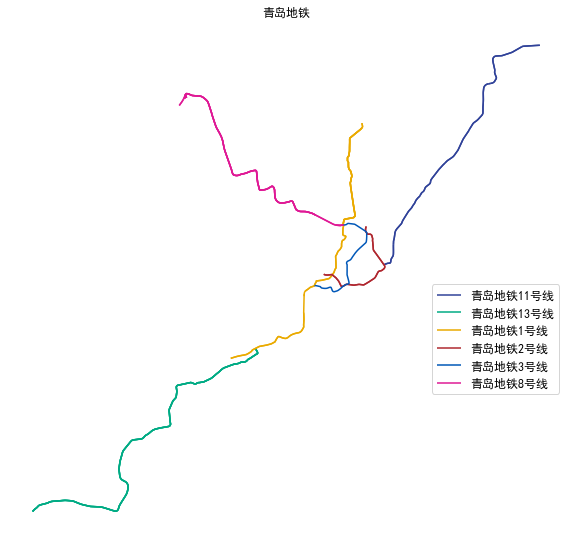

In [35]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='青岛地铁')

ax.set_axis_off()
plt.show()

In [36]:
infodata_qingdao = infodata[infodata['城市'] == '青岛市']
data_qingdao = pd.merge(geo_data_qingdao, infodata_qingdao, on='name')

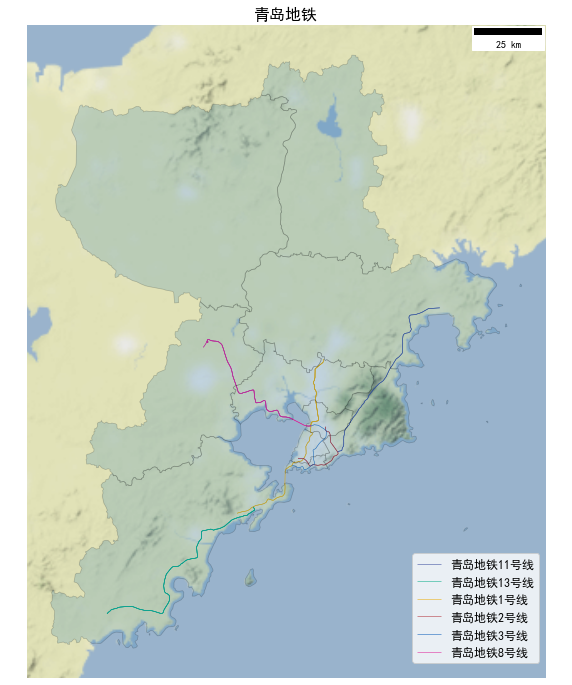

In [37]:
figure = plt.figure(figsize=(10, 12))

plt.title('青岛地铁', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)
    
axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 12})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁4.png', pad_inches=0, bbox_inches='tight', dpi=300)

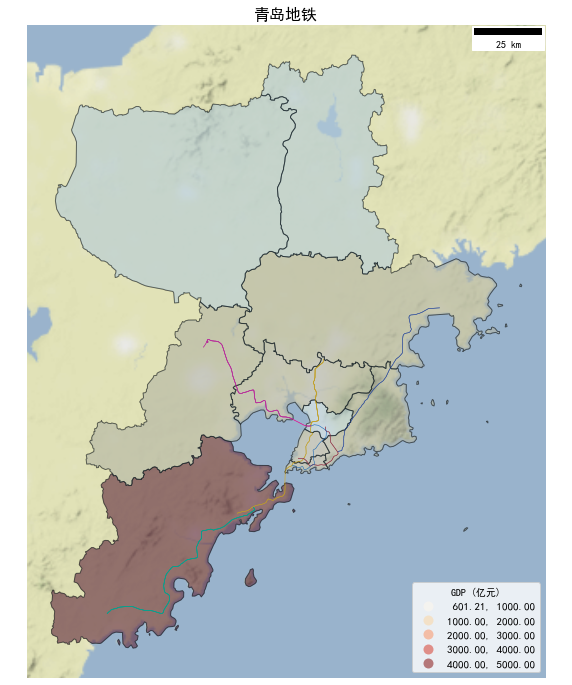

In [38]:
figure = plt.figure(figsize=(10, 12))

plt.title('青岛地铁', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

data_qingdao.plot(ax=axes1, column='GDP', alpha=0.5, edgecolor='k',
             categorical=False, legend=True,
             legend_kwds={'loc':'lower right', 'title':"GDP (亿元)", 'fontsize':'11'},
             scheme='User_Defined', classification_kwds=dict(bins=[1000,2000,3000,4000,5000]),
             cmap='OrRd', linewidth=1, label='GDP')

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)
    
#axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 11})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁5.png', pad_inches=0, bbox_inches='tight', dpi=300)

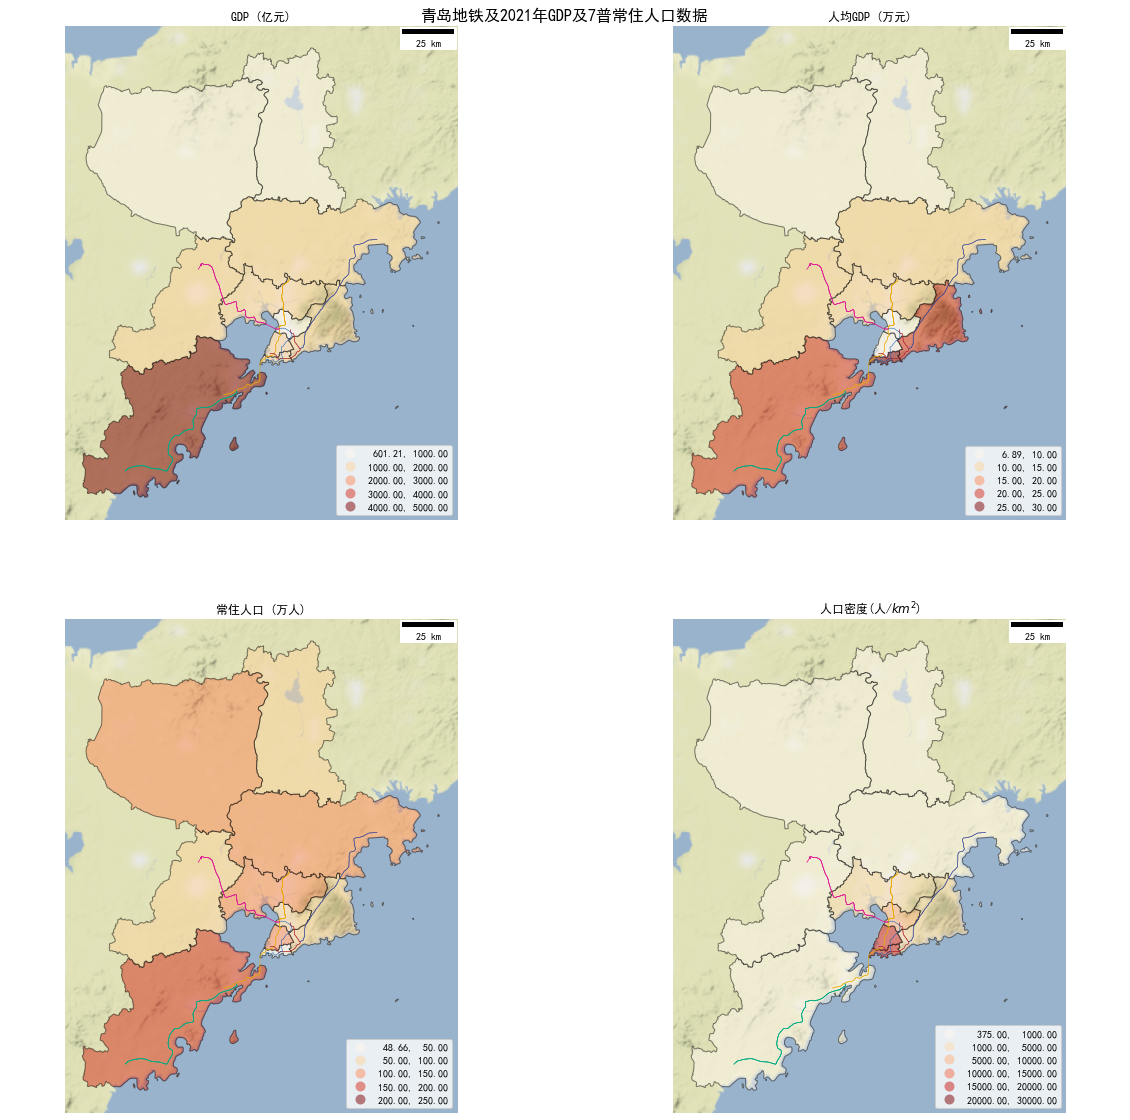

In [39]:
figure = plt.figure(figsize=(20, 20))

plt.title('青岛地铁及2021年GDP及7普常住人口数据', fontsize=16)
plt.axis('off')

axes1 = figure.add_subplot(2,2,1)
axes2 = figure.add_subplot(2,2,2)
axes3 = figure.add_subplot(2,2,3)
axes4 = figure.add_subplot(2,2,4)

#叠加GDP
data_qingdao.plot(ax=axes1, column='GDP', alpha=0.5, edgecolor='k',
                  categorical=False, legend=True, legend_kwds={'loc': 'lower right'},
                  scheme='User_Defined', classification_kwds=dict(bins=[1000,2000,3000,4000,5000]),
                  cmap='OrRd', linewidth=1)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    color = Lines_Palette[ctype]
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)
    
cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)
    
axes1.add_artist(ScaleBar(1))
axes1.axis('off')
axes1.set_title('GDP (亿元)')

#叠加人均GDP
data_qingdao.plot(ax=axes2, column='人均GDP', alpha=0.5, edgecolor='k',
                  categorical=False, legend=True, legend_kwds={'loc': 'lower right'},
                  scheme='User_Defined', classification_kwds={'bins':[10, 15, 20, 25, 30]},
                  cmap='OrRd', linewidth=1)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    color = Lines_Palette[ctype]
    data.plot(ax=axes2, color=color, label=ctype, linewidth=0.5)
    
cx.add_basemap(ax=axes2, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

axes2.add_artist(ScaleBar(1))
axes2.axis('off')
axes2.set_title('人均GDP (万元)')

#叠加常住人口
data_qingdao.plot(ax=axes3, column='常住人口', alpha=0.5, edgecolor='k',
                  categorical=False, legend=True, legend_kwds={'loc': 'lower right'},
                  scheme='User_Defined', classification_kwds=dict(bins=[50,100,150,200,250]),
                  cmap='OrRd', linewidth=1)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    color = Lines_Palette[ctype]
    data.plot(ax=axes3, color=color, label=ctype, linewidth=0.5)
    
cx.add_basemap(ax=axes3, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

axes3.add_artist(ScaleBar(1))
axes3.axis('off')
axes3.set_title('常住人口 (万人)')

#叠加人口密度
data_qingdao.plot(ax=axes4, column='人口密度', alpha=0.5, edgecolor='k',
                  categorical=False, legend=True, legend_kwds={'loc': 'lower right'},
                  scheme='User_Defined', classification_kwds=dict(bins=[1000,5000,10000,15000,20000, 30000]),
                  cmap='OrRd', linewidth=1)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    color = Lines_Palette[ctype]
    data.plot(ax=axes4, color=color, label=ctype, linewidth=0.5)
    
cx.add_basemap(ax=axes4, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

axes4.add_artist(ScaleBar(1))
axes4.axis('off')
axes4.set_title('人口密度(人/$km^2$)')

figure.savefig('青岛城市数据.png', pad_inches=0, bbox_inches='tight', dpi=300)

In [40]:
metro_stations = gpd.read_file('gis_osm_transport_free_1.shp').to_crs('EPSG:3857')

In [41]:
metro_data_qingdao_all

osm_id  code  fclass      name  layer bridge tunnel  \
113007  525096788  6103  subway  青岛地铁11号线      1      T      F   
113008  525096789  6103  subway  青岛地铁11号线      0      F      F   
113009  525096790  6103  subway  青岛地铁11号线     -1      F      T   
113010  525096792  6103  subway  青岛地铁11号线      1      T      F   
117672  546414706  6103  subway   青岛地铁2号线     -3      F      T   
...           ...   ...     ...       ...    ...    ...    ...   
113008  525096789  6103  subway  青岛地铁11号线      0      F      F   
113009  525096790  6103  subway  青岛地铁11号线     -1      F      T   
242415  968613224  6103  subway  青岛地铁11号线      0      F      F   
113010  525096792  6103  subway  青岛地铁11号线      1      T      F   
127283  583560507  6103  subway      None      1      T      F   

                                                 geometry  
113007  LINESTRING (13434685.565 4357926.229, 13434579...  
113008  LINESTRING (13434685.565 4357926.229, 13435162...  
113009  LINESTRING (13435162.468 4358027.418, 13435314...  
113010  LINESTRING (13436069.667 4358429.543, 13436133...  
117672  LINESTRING (13398750.319 4310270.586, 13398803...  
...                                                   ...  
113008  LINESTRING (13434685.565 4357926.229, 13435162...  
113009  LINESTRING (13435162.468 4358027.418, 13435314...  
242415  LINESTRING (13435762.692 4358187.193, 13435843...  
113010  LINESTRING (13436069.667 4358429.543, 13436133...  
127283  LINESTRING (13437108.912 4364651.399, 13437132...  

[283 rows x 8 columns]

In [42]:
#metro_data_qingdao_stations__ = gpd.clip(metro_stations, metro_data_qingdao_all)
#metro_data_qingdao_stations__

In [43]:
metro_data_qingdao_stations = gpd.clip(metro_stations, geo_data_qingdao)
#metro_data_qingdao_stations = metro_data_qingdao_stations[~metro_data_qingdao_stations.is_empty]
metro_data_qingdao_stations['fclass'].unique()

array(['railway_station', 'bus_stop', 'bus_station', 'taxi',
       'ferry_terminal', 'helipad', 'tram_stop'], dtype=object)

In [44]:
metro_data_qingdao_stations = metro_data_qingdao_stations[metro_data_qingdao_stations['fclass'] == 'railway_station']

In [45]:
metro_data_qingdao_stations

osm_id  code           fclass  name  \
63633   6182217383  5601  railway_station    琅琊   
63632   6182217382  5601  railway_station   贡口湾   
63634   6182217384  5601  railway_station    龙湾   
117037  9242869575  5601  railway_station  肖家贡村   
84547   8093918592  5601  railway_station  董家口南   
...            ...   ...              ...   ...   
78437   7721237366  5601  railway_station   夏格庄   
28701   3914214623  5601  railway_station   莱西南   
63755   6210802486  5601  railway_station    莱西   
57897   5579085311  5601  railway_station    浦里   
57898   5579086021  5601  railway_station   鳌山卫   

                                geometry  
63633   POINT (13343870.245 4255432.876)  
63632   POINT (13339657.236 4256226.070)  
63634   POINT (13346881.214 4258078.896)  
117037  POINT (13330835.100 4248580.837)  
84547   POINT (13330406.397 4253199.616)  
...                                  ...  
78437   POINT (13407474.918 4390610.321)  
28701   POINT (13415439.337 4412468.284)  
63755   POINT (13416823.773 4414472.177)  
57897   POINT (13427749.848 4342852.544)  
57898   POINT (13431364.080 4348728.450)  

[161 rows x 5 columns]

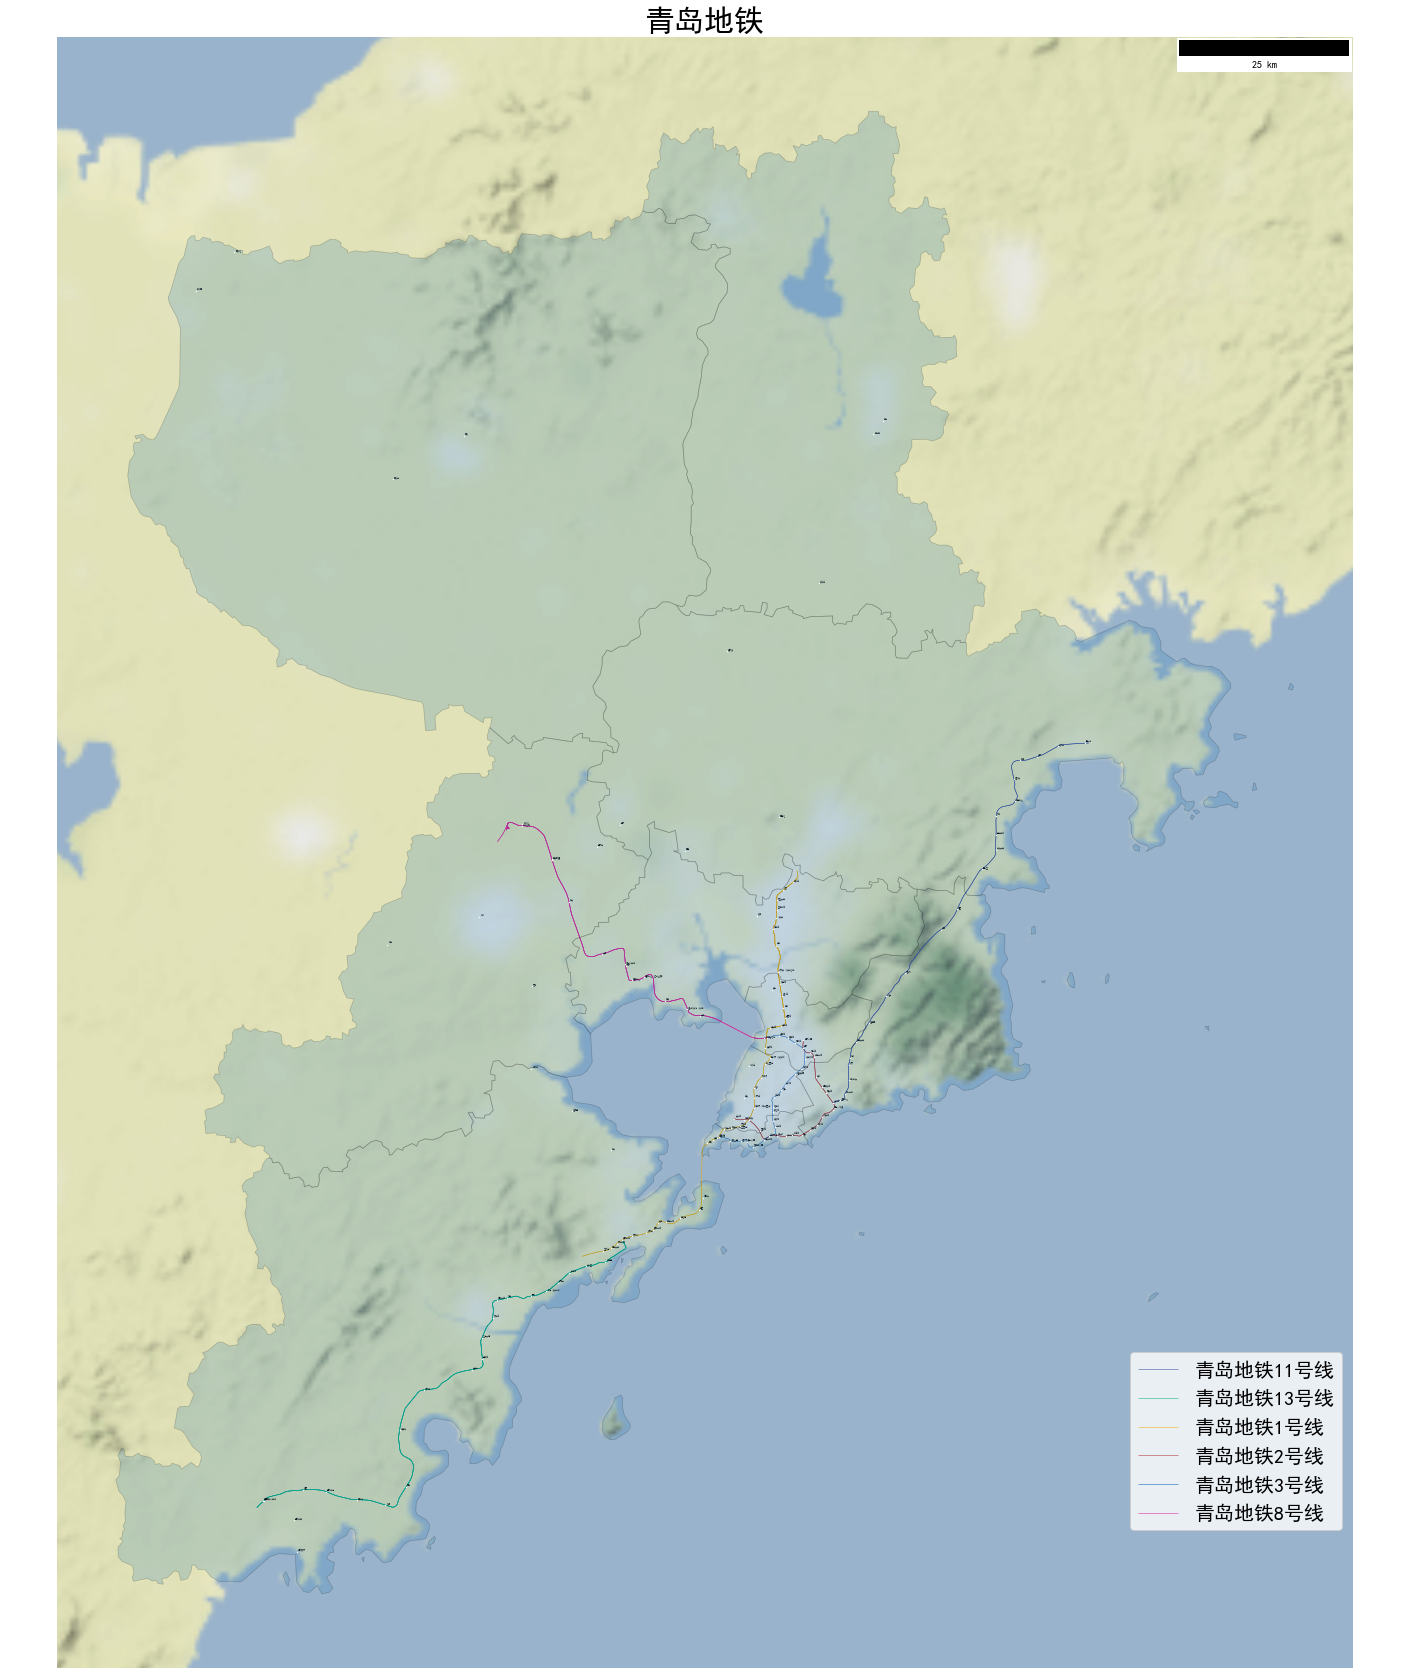

In [46]:
figure = plt.figure(figsize=(25, 30))

plt.title('青岛地铁', fontsize=30)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)

metro_data_qingdao_stations.plot(ax=axes1, marker='*', markersize=0.2, color='white', zorder=10)
for x, y, label in zip(metro_data_qingdao_stations.geometry.x, metro_data_qingdao_stations.geometry.y,
                       metro_data_qingdao_stations.name):
    axes1.annotate(label, xy=(x, y), xytext=(1,1), textcoords='offset points', fontsize=2)
    
axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 20})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁6.png', pad_inches=0, bbox_inches='tight', dpi=300)

In [47]:
metro_data_qingdao_stations_railway = pd.read_excel('metro_qingdao_station~.xlsx')
metro_data_qingdao_stations_railway

station
0      新河园
1       平度
2      平度西
3      平度北
4       莱西
5      莱西南
6      夏格庄
7      姜家坡
8       蓝村
9       即墨
10     即墨北
11     蓝村西
12      胶州
13      营海
14    青岛机场
15      胶西
16     胶州北
17     洋河口
18     红石崖
19      黄岛
20     董家口
21    董家口南
22    肖家贡村
23      城阳
24      娄山
25     青岛北
26     沙岭庄
27      四方
28      青岛
29      红岛

In [48]:
metro_data_qingdao_stations_railway_list = metro_data_qingdao_stations_railway['station'].tolist()
metro_data_qingdao_stations_railway_list

['新河园',
 '平度',
 '平度西',
 '平度北',
 '莱西',
 '莱西南',
 '夏格庄',
 '姜家坡',
 '蓝村',
 '即墨',
 '即墨北',
 '蓝村西',
 '胶州',
 '营海',
 '青岛机场',
 '胶西',
 '胶州北',
 '洋河口',
 '红石崖',
 '黄岛',
 '董家口',
 '董家口南',
 '肖家贡村',
 '城阳',
 '娄山',
 '青岛北',
 '沙岭庄',
 '四方',
 '青岛',
 '红岛']

In [49]:
#metro_data_qingdao_stations = metro_data_qingdao_stations.loc[~metro_data_qingdao_stations.name.isin(metro_data_qingdao_stations_railway_list)]
metro_data_qingdao_stations = metro_data_qingdao_stations.query('@metro_data_qingdao_stations_railway_list not in name')

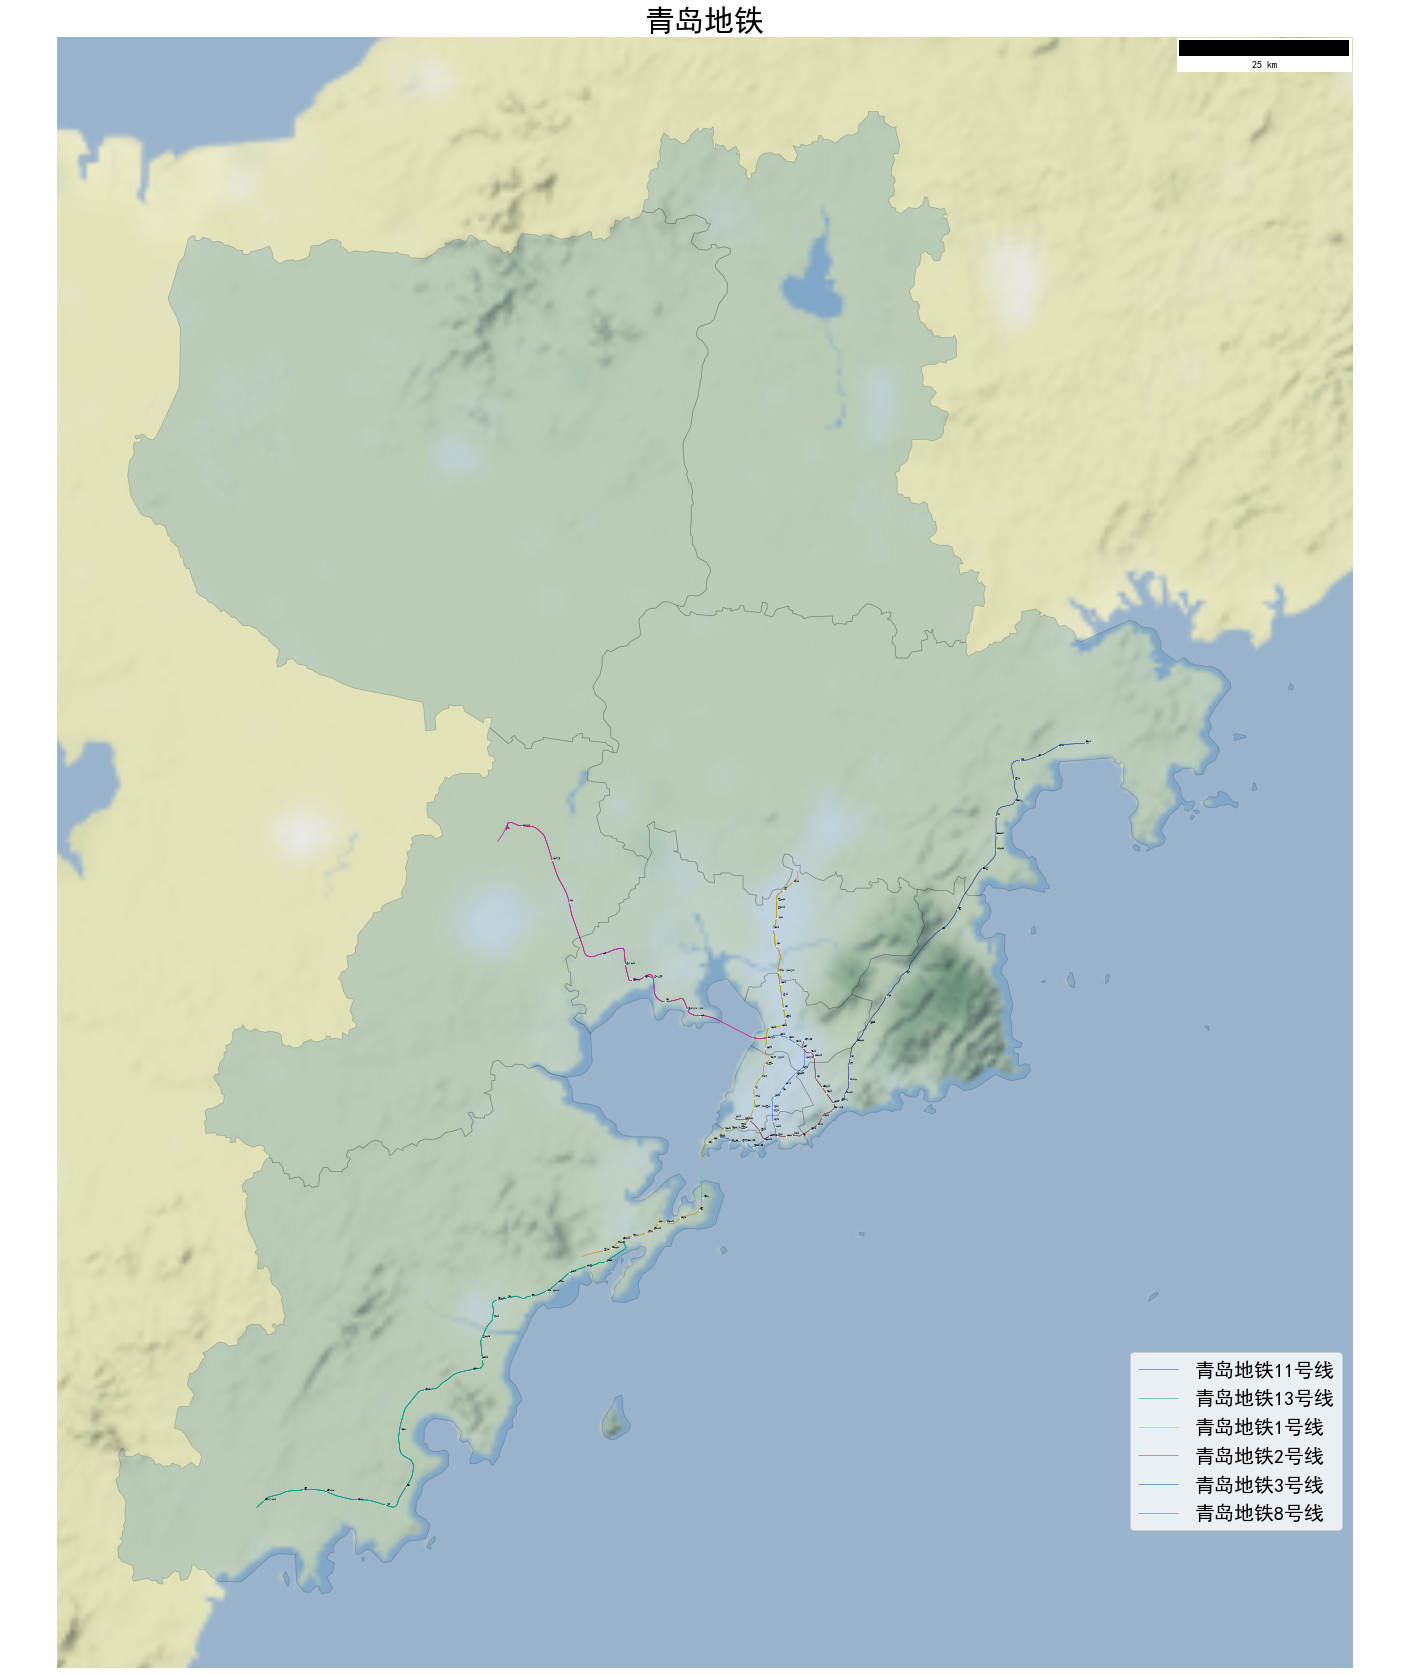

In [50]:
figure = plt.figure(figsize=(25, 30))

plt.title('青岛地铁', fontsize=30)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)

metro_data_qingdao_stations.plot(ax=axes1, marker='*', markersize=0.2, color='white', zorder=10)
for x, y, label in zip(metro_data_qingdao_stations.geometry.x, metro_data_qingdao_stations.geometry.y,
                       metro_data_qingdao_stations.name):
    axes1.annotate(label, xy=(x, y), xytext=(1,1), textcoords='offset points', fontsize=2)
    
axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 20})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁7.png', pad_inches=0, bbox_inches='tight', dpi=300)

In [51]:
geo_data_qingdao = gpd.read_file('青岛市-WGS-84.geojson').to_crs('EPSG:3857')

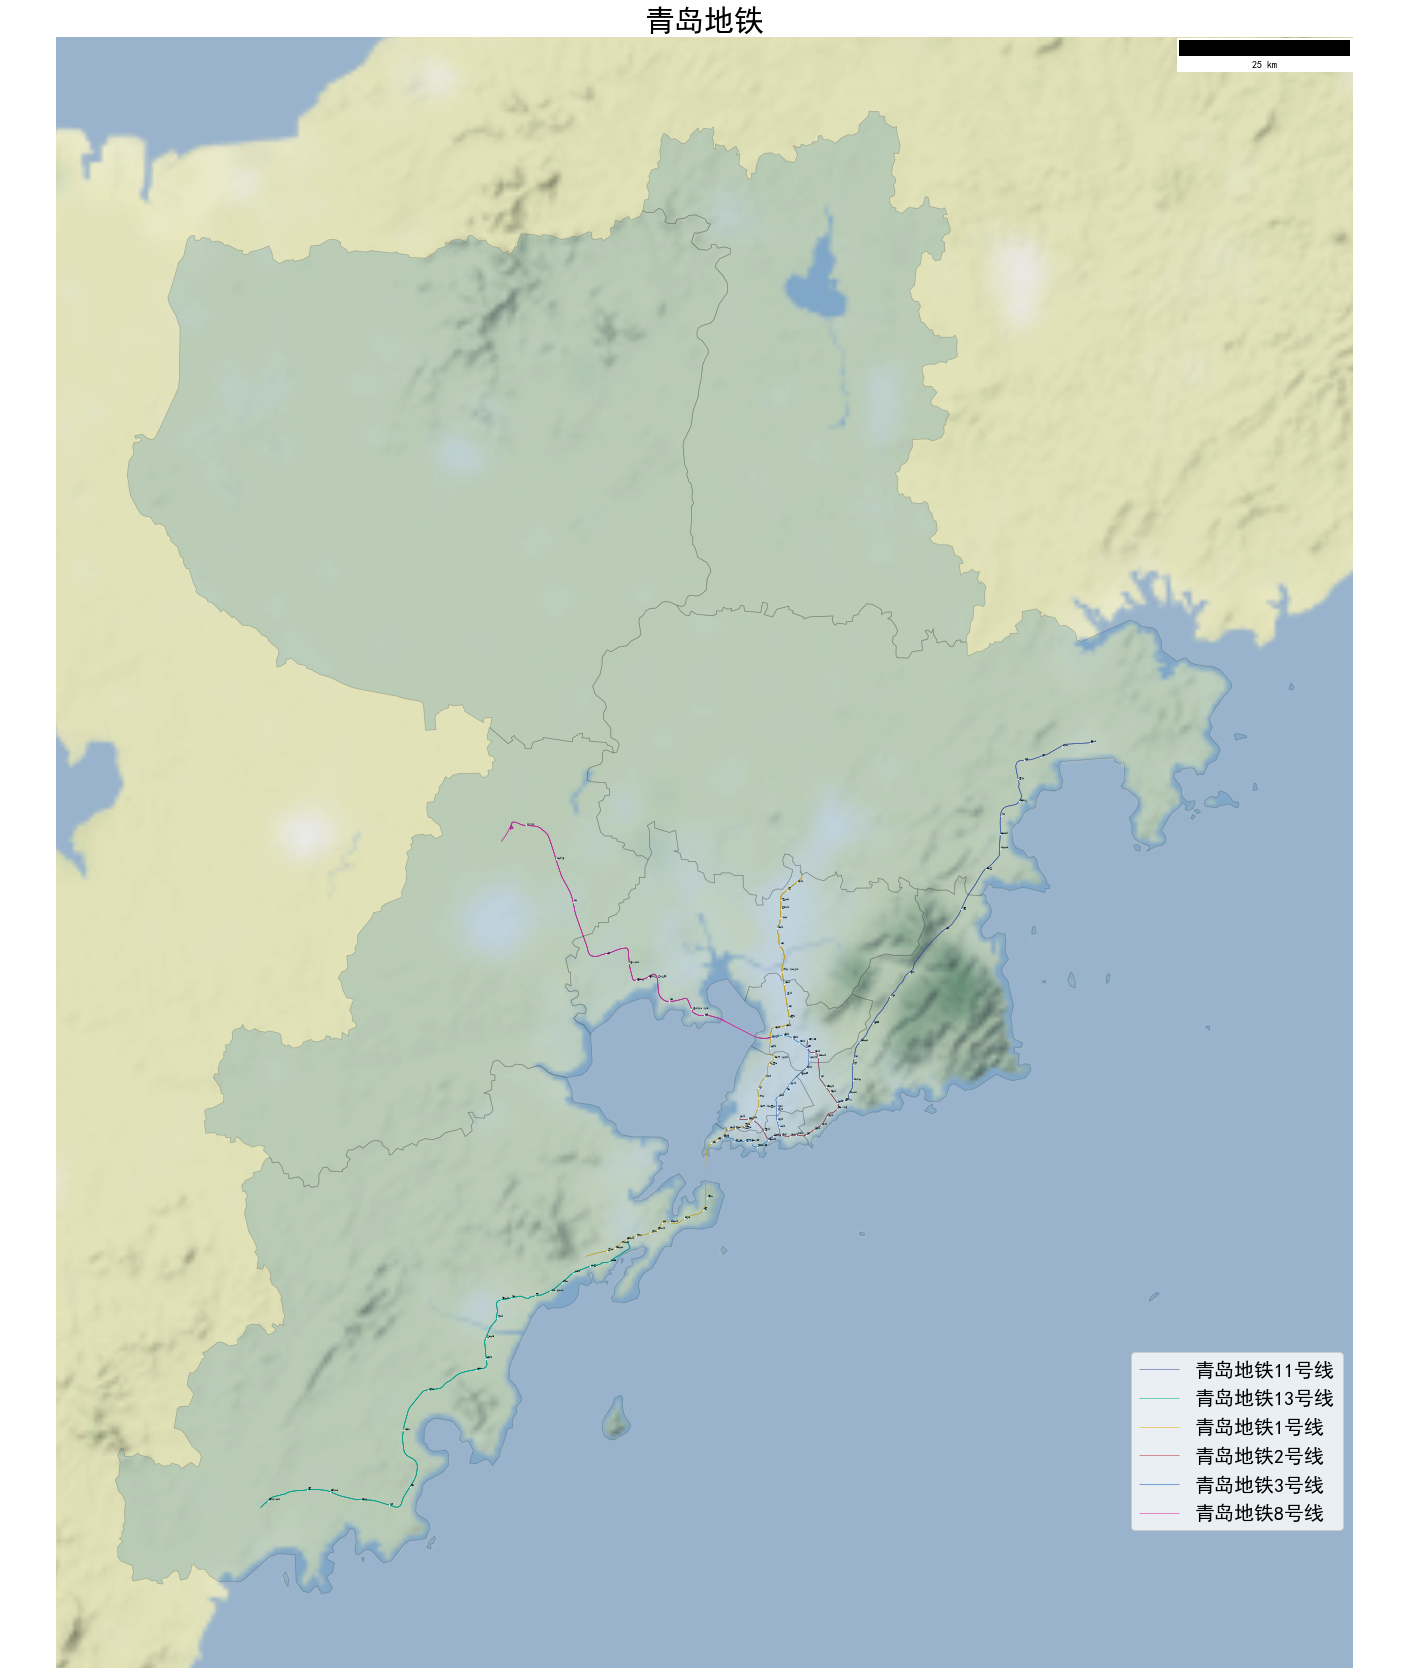

In [52]:
figure = plt.figure(figsize=(25, 30))

plt.title('青岛地铁', fontsize=30)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)

metro_data_qingdao_stations.plot(ax=axes1, marker='*', markersize=0.2, color='white', zorder=10)
for x, y, label in zip(metro_data_qingdao_stations.geometry.x, metro_data_qingdao_stations.geometry.y,
                       metro_data_qingdao_stations.name):
    axes1.annotate(label, xy=(x, y), xytext=(1,1), textcoords='offset points', fontsize=2)
    
axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 20})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁8.png', pad_inches=0, bbox_inches='tight', dpi=300)

绘制`zoom level=10`的高清地图

```python
figure = plt.figure(figsize=(25, 30))

plt.title('青岛地铁', fontsize=30)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)

metro_data_qingdao_stations.plot(ax=axes1, marker='*', markersize=0.2, color='white', zorder=10)
for x, y, label in zip(metro_data_qingdao_stations.geometry.x, metro_data_qingdao_stations.geometry.y,
                       metro_data_qingdao_stations.name):
    axes1.annotate(label, xy=(x, y), xytext=(1,1), textcoords='offset points', fontsize=2)
    
axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 20})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=10)

figure.savefig('青岛地铁8-zl10.png', pad_inches=0, bbox_inches='tight', dpi=500)
```

```python
figure = plt.figure(figsize=(25, 30))

plt.title('青岛地铁', fontsize=30)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):

    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]

    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype, linewidth=0.5)

metro_data_qingdao_stations.plot(ax=axes1, marker='*', markersize=0.2, color='white', zorder=10)
for x, y, label in zip(metro_data_qingdao_stations.geometry.x, metro_data_qingdao_stations.geometry.y,
                       metro_data_qingdao_stations.name):
    axes1.annotate(label, xy=(x, y), xytext=(1,1), textcoords='offset points', fontsize=2)

axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 20})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png', zoom=12)
#cx.add_basemap(ax=axes1, source='http://{s}.tile.stamen.com/toner/{z}/{x}/{y}.png', zoom=8)
#cx.add_basemap(ax=axes1, source='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', zoom=12)
#cx.add_basemap(ax=axes1, source='http://a.tile.openstreetmap.org/Z/X/Y.png', zoom=8)

figure.savefig('青岛地铁8-zl12.png', pad_inches=0, bbox_inches='tight', dpi=500)
```

In [60]:
metro_qingdao_pop = pd.read_excel('metro_qingdao_pop.xlsx')
metro_qingdao_pop

Lines  Line_width   pop  length  Line_width_
0    青岛地铁1号线         2.4  23.0   60.11          0.4
1    青岛地铁2号线         3.0  29.0   25.09          1.2
2    青岛地铁3号线         3.0  29.0   24.95          1.2
3    青岛地铁4号线         0.0   NaN     NaN          NaN
4    青岛地铁5号线         0.0   NaN     NaN          NaN
5    青岛地铁6号线         0.0   NaN     NaN          NaN
6    青岛地铁7号线         0.0   NaN     NaN          NaN
7    青岛地铁8号线         0.4   4.0   49.61          0.1
8    青岛地铁9号线         0.0   NaN     NaN          NaN
9   青岛地铁10号线         0.0   NaN     NaN          NaN
10  青岛地铁11号线         0.5   5.0   58.35          0.1
11  青岛地铁12号线         0.0   NaN     NaN          NaN
12  青岛地铁13号线         0.6   6.0   67.04          0.1
13  青岛地铁14号线         0.0   NaN     NaN          NaN
14  青岛地铁15号线         0.0   NaN     NaN          NaN
15  青岛地铁16号线        10.0  96.0  285.15          0.3

In [61]:
Lines_Width = dict([(i,a) for i,a in zip(metro_qingdao_pop['Lines'], metro_qingdao_pop['Line_width_'])])
Lines_Width

{'青岛地铁1号线': 0.4,
 '青岛地铁2号线': 1.2,
 '青岛地铁3号线': 1.2,
 '青岛地铁4号线': nan,
 '青岛地铁5号线': nan,
 '青岛地铁6号线': nan,
 '青岛地铁7号线': nan,
 '青岛地铁8号线': 0.1,
 '青岛地铁9号线': nan,
 '青岛地铁10号线': nan,
 '青岛地铁11号线': 0.1,
 '青岛地铁12号线': nan,
 '青岛地铁13号线': 0.1,
 '青岛地铁14号线': nan,
 '青岛地铁15号线': nan,
 '青岛地铁16号线': 0.3}

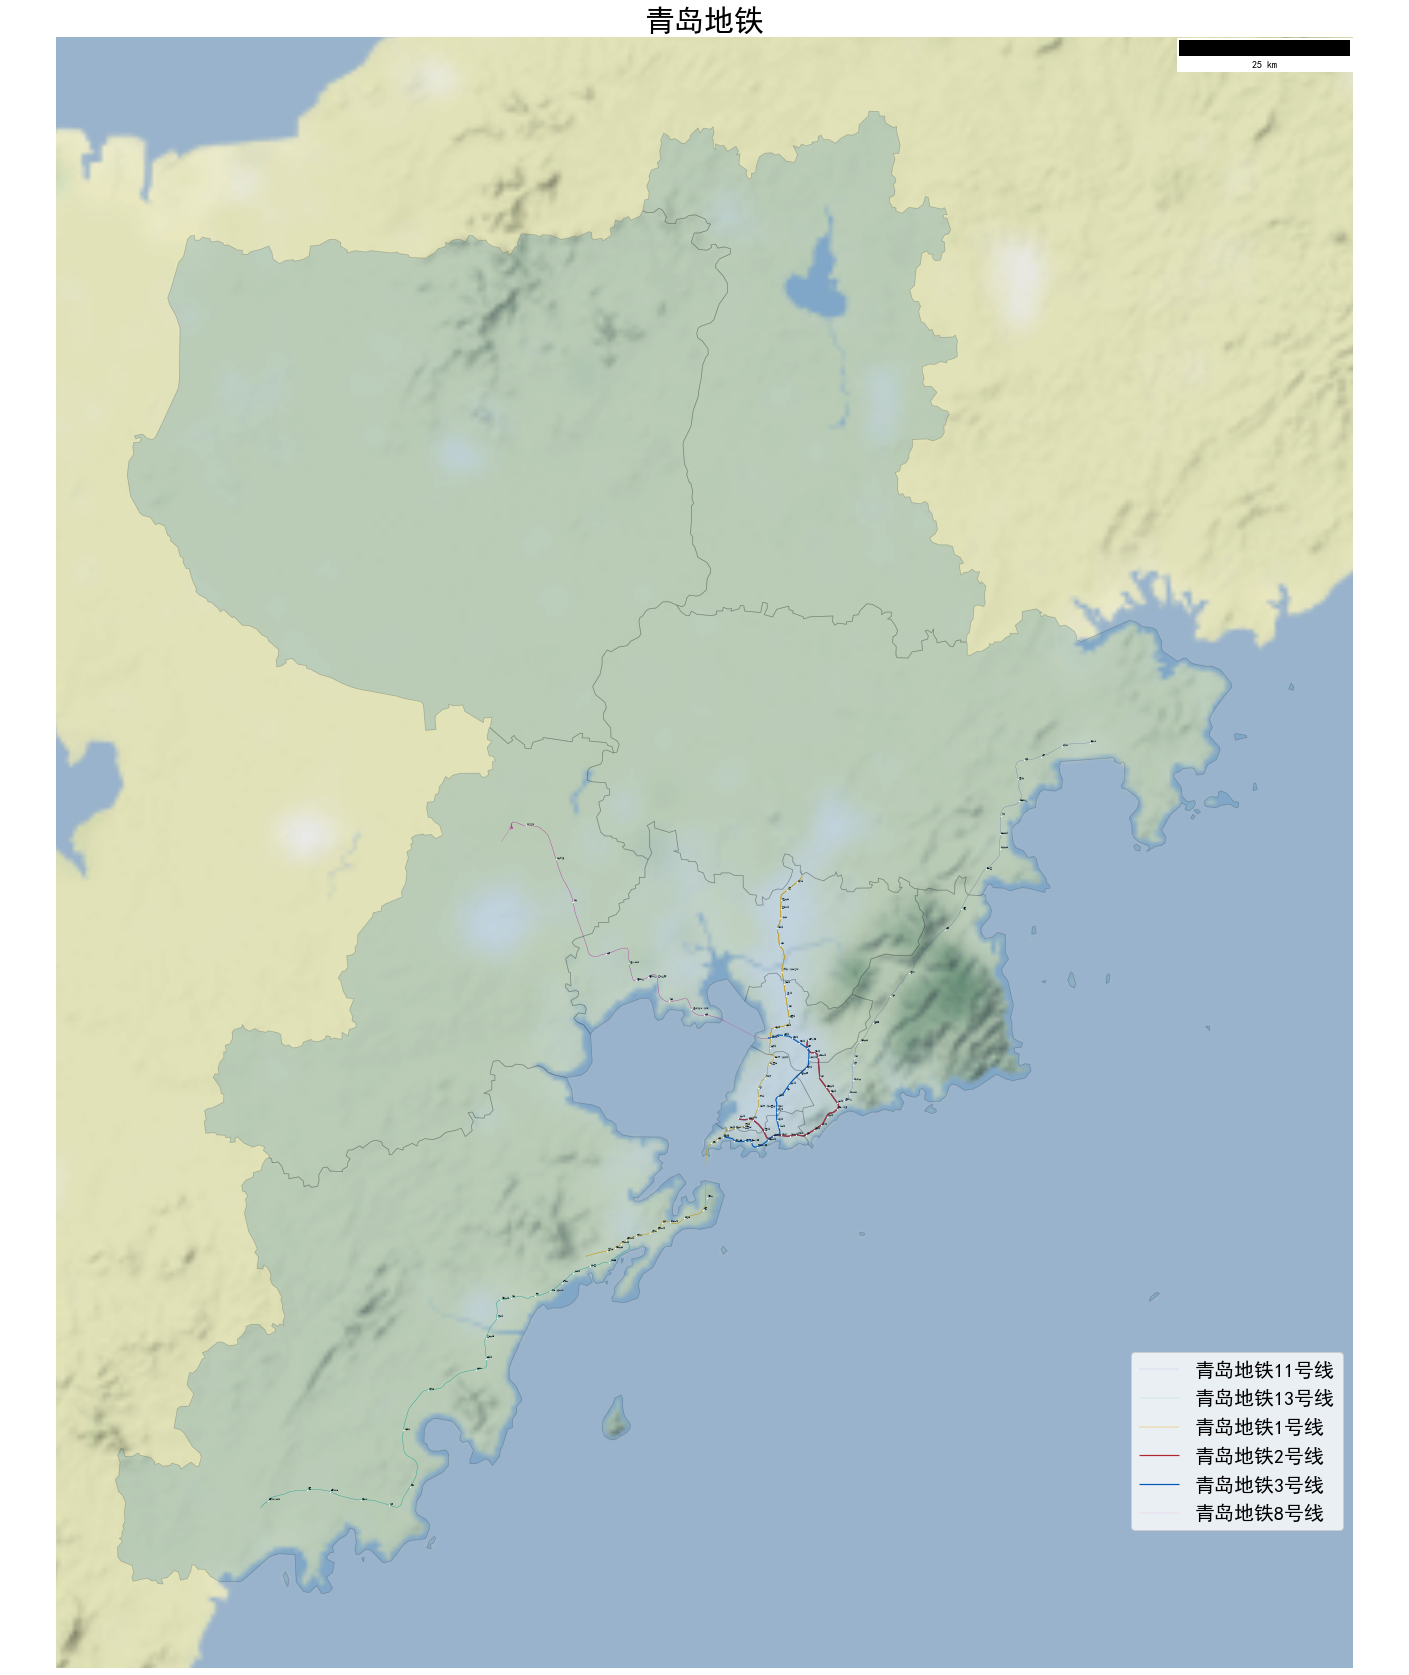

In [66]:
figure = plt.figure(figsize=(25, 30))

plt.title('青岛地铁', fontsize=30)
plt.axis('off')

axes1 = figure.add_subplot(1,1,1)
axes1.axis('off')

geo_data_qingdao.plot(ax=axes1, alpha=0.2, edgecolor='k', linewidth=0.7, zorder=5)

for ctype, data in metro_data_qingdao_all.groupby('name'):
    
    # Define the color for each group using the dictionary
    color = Lines_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(ax=axes1, color=color, label=ctype,
             # Assign each group to a line width using the dictionary created above
              linewidth=Lines_Width[ctype])

metro_data_qingdao_stations.plot(ax=axes1, marker='*', markersize=0.2, color='white', zorder=10)
for x, y, label in zip(metro_data_qingdao_stations.geometry.x, metro_data_qingdao_stations.geometry.y,
                       metro_data_qingdao_stations.name):
    axes1.annotate(label, xy=(x, y), xytext=(1,1), textcoords='offset points', fontsize=2)
    
axes1.legend(bbox_to_anchor=(1.0, 0.2), prop={'size': 20})
axes1.add_artist(ScaleBar(1))

cx.add_basemap(ax=axes1, source='https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png', zoom=8)

figure.savefig('青岛地铁9.png', pad_inches=0, bbox_inches='tight', dpi=500)